Group all imports

In [1]:
import json
from datetime import datetime
import os
from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from colorama import Fore, Style
import sys  # For printing caught exceptions
import re
from Powerfleet_APIs_Management import MongoDBConnector as DBConnector
from pathlib import Path
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd


Uodate <u>PARAMETERS.json</u> with **current** date and time

In [2]:
file_path = "PARAMETERS.json" 

# Get the current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
current_time = datetime.now().strftime("%H:%M:%S")  # Format as HH:MM:SS

# Check if the file exists and is not empty
if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' does not exist.")
    exit()

# Check if the file is empty
if os.path.getsize(file_path) == 0:
    print(f"Error: The file '{file_path}' is empty.")
    exit()

# Load the current JSON data
try:
    with open(file_path, "r") as file:
        data = json.load(file)
except json.JSONDecodeError as e:
    print(f"Error: Failed to decode JSON. Details: {e}")
    exit()

# Combine the date and time
combined_datetime = current_datetime + " " + current_time

# Update the 'endDate' field in the 'snapshot_api' section
data["snapshot_api"]["endDate"] = combined_datetime

# Save the updated JSON data back to the file
try:
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)  # Use indent for readable JSON formatting
    print(f"Updated PARAMETERS.json with: {combined_datetime}.")
except Exception as e:
    print(f"Error: Failed to save the updated file. Details: {e}")


Updated PARAMETERS.json with: 2024-12-13 18:45:07.


<!-- Initialize **API** **managers** -->

In [3]:
print(Fore.YELLOW + f"MAIN CWD={os.getcwd()}")
print(f"MAIN, LISTDIR={os.listdir()}" + Style.RESET_ALL)

# Define the ApiParameterExtractor class
class ApiParameterExtractor:
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            self.parameters = json.load(file)

    def extract_parameters(self, api_type):
        # Normalize API type to lowercase
        api_type = api_type.lower()
        
        # Validate API type
        if api_type not in self.parameters:
            raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")
        
        # Return the corresponding dictionary for the given API type
        return self.parameters[api_type]


extractor = ApiParameterExtractor("PARAMETERS.json")

# Extract parameters for live_api and snapshot_api
live_api_params         = extractor.extract_parameters("live_api")
snapshot_api_params     = extractor.extract_parameters("snapshot_api")

# Pass the extracted parameters to PowerFleetAPIsManager
live_api_manager        = ApiManager(live_api_params)
snapshot_api_manager    = ApiManager(snapshot_api_params)




MAIN CWD=/home/georger/WorkDocuments/Sxoli/Ptyxiaki/Ptyxiaki-Repository/Python_Scripts/Data_Analysis
MAIN, LISTDIR=['Powerfleet_APIs_Management.py', 'segment_1.csv', 'Plots', 'PARAMETERS.json', '__pycache__', 'data_analysis.ipynb']


(Optional) Update mongoDB for visualizing coordinates

In [4]:
connector = DBConnector()
if connector.check_connection():
    print("Proceed with operations.")
else:
    print("Fix connection issues before proceeding.")

Connection to MongoDB is successful!
Proceed with operations.


1. Convert **JSON** to **CSV** so that **pandas** be able to use it
2. Create **csv** for every vehicle



In [5]:
# === Function to Save DataFrame to CSV ===
def save_to_csv(dataframe, output_dir, file_name):
    """
    Save a DataFrame to a specified CSV file in the given directory.
    
    :param dataframe: The DataFrame to save.
    :param output_dir: The directory where the CSV file will be saved.
    :param file_name: The name of the CSV file (e.g., "file_name.csv").
    """
    if not dataframe.empty:  # Only save if the DataFrame is not empty
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        file_path = Path(output_dir) / file_name  # Construct the full file path
        dataframe.to_csv(file_path, index=False)  # Save the DataFrame to CSV
        print(f"Data saved to {file_path}")
    else:
        print(f"No data to save for {file_name}. Skipping...")

# === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
def unix_to_datetime_pandas(dataframe, column_name):
    """
    Convert a UNIX timestamp column to human-readable datetime format.
    
    :param dataframe: The DataFrame containing the column.
    :param column_name: The column name containing UNIX timestamps.
    """
    if column_name in dataframe.columns:
        try:
            dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
            print(f"Converted '{column_name}' to human-readable datetime.")
        except Exception as e:
            print(f"Error converting column '{column_name}': {e}")
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

# === Constants ===
target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Modify with your source CSV path

# === Step 1: Read Headers from the Source File ===
with open(snapshot_csv_path, mode="r") as infile:
    reader = csv.reader(infile)
    headers = next(reader)  # Extract headers from the source file

# === Step 2: Write Headers to the Target File ===
with open(target_file, mode="w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers)  # Write the headers into the target file

# === Step 3: Load Parameters from JSON File ===
with open("PARAMETERS.json", "r") as file:
    PARAMETERS = json.load(file)  # Load API parameters from the JSON file

# === Step 4: Loop to Fetch and Append Data for Each Vehicle ===
_cnt = 1  # Counter for vehicle IDs
snapshot_data = None  # Initialize snapshot_data to enter the loop

while _cnt <= 100:  # Run for up to 100 times
    # Update the vehicleId in PARAMETERS
    PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
    
    # Extract updated vehicleId and fetch snapshot data
    vehicleId = PARAMETERS["snapshot_api"]["vehicleId"]
    startDate = PARAMETERS["snapshot_api"]["startDate"]
    endDate = PARAMETERS["snapshot_api"]["endDate"]
    
    # Fetch snapshot data (Returns JSON)
    snapshot_data = snapshot_api_manager.get_snapshot_data(vehicleId, startDate, endDate)
    
    # Skip if no data is found (None or empty data)
    if not snapshot_data:
        print(f"No data found for vehicleId {vehicleId}. Skipping...")
        _cnt += 1
        continue
    
    # Parse the JSON snapshot data into a DataFrame
    try:
        # If the snapshot data is a valid JSON string, parse it
        snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
        
        # Handle JSON structure (either dict or list)
        if isinstance(snapshot_data_dict, dict):
            snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
        elif isinstance(snapshot_data_dict, list):
            snapshot_data_list = snapshot_data_dict  # Already a list of dicts
        else:
            snapshot_data_list = []
        
        # Create a DataFrame from the list of dictionaries
        snapshot_df = pd.DataFrame(snapshot_data_list)
        
        # Convert UNIX timestamps in 'dateStored' column to human-readable format
        unix_to_datetime_pandas(snapshot_df, 'dateStored')
        
        # Save the DataFrame to CSV only if it's not empty
        save_to_csv(snapshot_df, "../../DataSets/API_Responses/Vehicle_Data", f"Vehicle_{_cnt}_response.csv")
    
    except json.JSONDecodeError as e:
        print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

    # Increment the vehicleId counter
    _cnt += 1

print("Process complete!")


**Snapshot API**
Snapshot API Request Successful!
Converted 'dateStored' to human-readable datetime.
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_1_response.csv
**Snapshot API**
Snapshot API Request Successful!
Converted 'dateStored' to human-readable datetime.
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_2_response.csv
**Snapshot API**
Snapshot API Request Successful!
Converted 'dateStored' to human-readable datetime.
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_3_response.csv
**Snapshot API**
Snapshot API Request Successful!
Converted 'dateStored' to human-readable datetime.
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_4_response.csv
**Snapshot API**
Snapshot API Request Successful!
Converted 'dateStored' to human-readable datetime.
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_5_response.csv
**Snapshot API**
Snapshot API Request Successful!
Converted 'dateStored' to human-readable datetime.

Visualize data **dispersion**

In [6]:
PLOT_FOLDER_PATH = './Plots/'

1) Plot **unique** vehicles

Error reading Vehicle_15_response_formatted.csv: No columns to parse from file


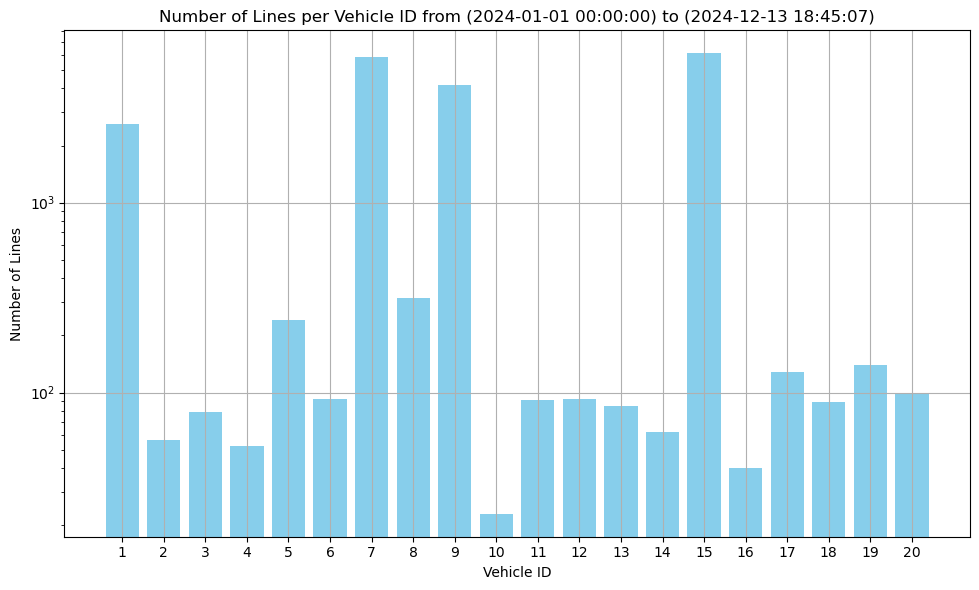

In [7]:
# Path to the folder containing the CSV files
folder_path = "../../DataSets/API_Responses/Vehicle_Data/"  # Modify with your folder path

# Initialize an empty dictionary to store vehicleId (as an integer for sorting) and its corresponding row count
vehicle_lines = {}

# Loop through the files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file and starts with "Vehicle_"
    if file_name.endswith(".csv") and file_name.startswith("Vehicle_"):
        # Extract the vehicleId from the file name (assuming the naming convention is 'Vehicle_<id>.csv')
        vehicle_id_str = file_name.split('_')[1].split('.')[0]  # Extract the part after "Vehicle_" and before ".csv"
        
        # Ensure vehicle_id is numeric; if not, skip the file
        try:
            vehicle_id = int(vehicle_id_str)  # Convert to integer for proper sorting
        except ValueError:
            print(f"Skipping file with non-numeric Vehicle ID: {file_name}")
            continue

        # Construct the full path to the file
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file to count the number of rows (excluding the header)
        try:
            df = pd.read_csv(file_path)
            vehicle_lines[vehicle_id] = len(df)  # Store the line count for each vehicleId
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

# Sort the dictionary by vehicleId (numerically in ascending order)
sorted_vehicle_lines = dict(sorted(vehicle_lines.items()))

# Convert the sorted dictionary to two lists for plotting
vehicle_ids = list(sorted_vehicle_lines.keys())
line_counts = list(sorted_vehicle_lines.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(vehicle_ids, line_counts, color='skyblue')
plt.xlabel('Vehicle ID')
plt.ylabel('Number of Lines')
plt.title(f'Number of Lines per Vehicle ID from ({PARAMETERS["snapshot_api"]["startDate"]}) to ({PARAMETERS["snapshot_api"]["endDate"]})')
plt.xticks(vehicle_ids)  # Rotate vehicle IDs if needed
plt.tight_layout()
plt.grid()

# Set a logarithmic scale for better visualization of large variations
plt.yscale("log")

# Show and save the plot
plt.savefig(os.path.join(PLOT_FOLDER_PATH, 'compare_all_vehicles.png'))
plt.show()


2. **vehicleId=15** seems to have the most lines. Plot it's **velocities**

In [8]:
VEHICLE_15_PATH = "../../DataSets/API_Responses/Vehicle_Data/Vehicle_15_response.csv"

# Load the CSV file into a DataFrame
data = pd.read_csv(VEHICLE_15_PATH)

# Convert the 'dateStored' column to datetime format for filtering
data['dateStored'] = pd.to_datetime(data['dateStored'])

#! Sort the DataFrame by 'dateStored' in ascending order
data_sorted = data.sort_values(by='dateStored', ascending=True)

#* Extract columns of interest from the sorted data
lat_clmn = data_sorted['lat']
long_clmn = data_sorted['lng']
date_stored = data_sorted['dateStored']


# Check the first few rows of the sorted data
print(data_sorted.head())


   vehicleId        lat        lng          dateStored  velocity  odometer  \
0         15  38.034933  23.748265 2024-05-22 13:08:22       0.0       0.0   
1         15  38.034833  23.747995 2024-05-22 13:08:23       1.0       0.0   
2         15  38.034692  23.748035 2024-05-22 13:08:59       0.0       0.0   
3         15  38.034720  23.748038 2024-05-22 13:15:16       8.0       0.0   
4         15  38.034725  23.748063 2024-05-22 13:15:22       6.0       0.0   

   engineVoltage  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


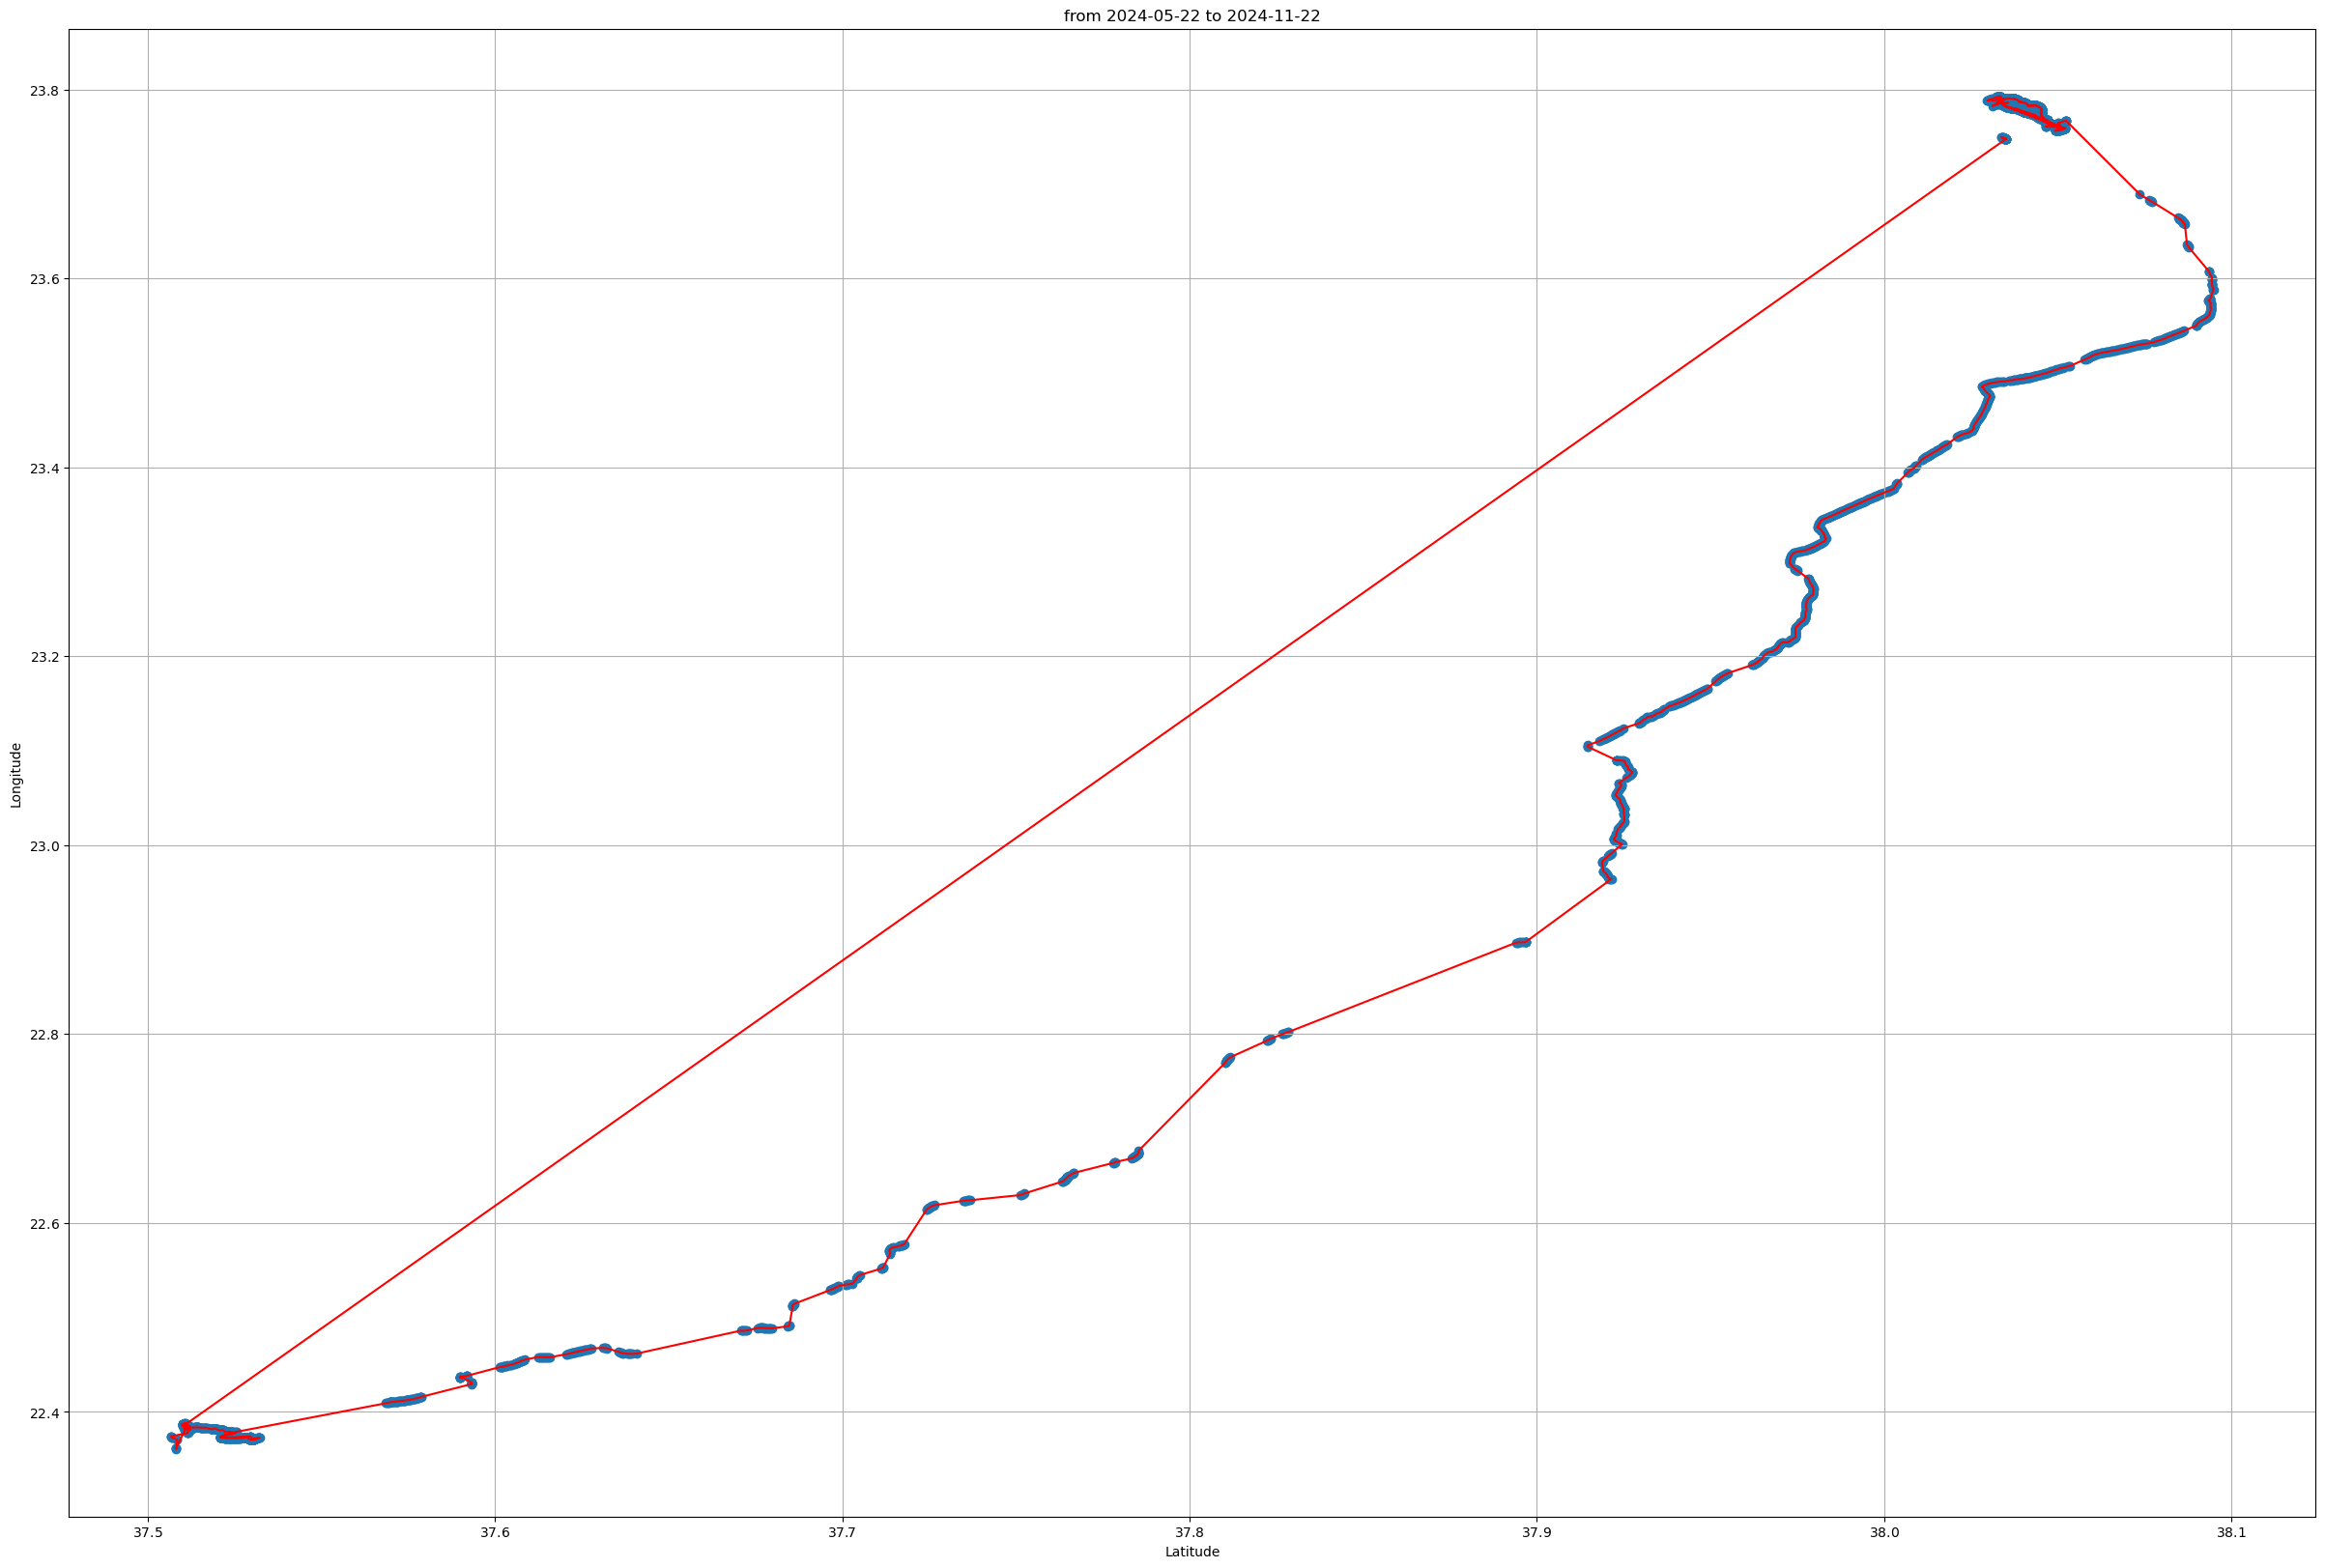

In [9]:
plt.figure(figsize=(30, 20))
plt.title(f'from {date_stored.iloc[0].strftime("%Y-%m-%d")} to {date_stored.iloc[-1].strftime("%Y-%m-%d")}')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Disable scientific notation on both axes
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

# Turn off offset notation
plt.gca().ticklabel_format(useOffset=False)

plt.grid()
plt.scatter(lat_clmn, long_clmn)
plt.plot(lat_clmn, long_clmn, color='r')
plt.savefig(os.path.join(PLOT_FOLDER_PATH, 'vehicle_15_coordinates'))
plt.show()



Plot all trips of current vehicle

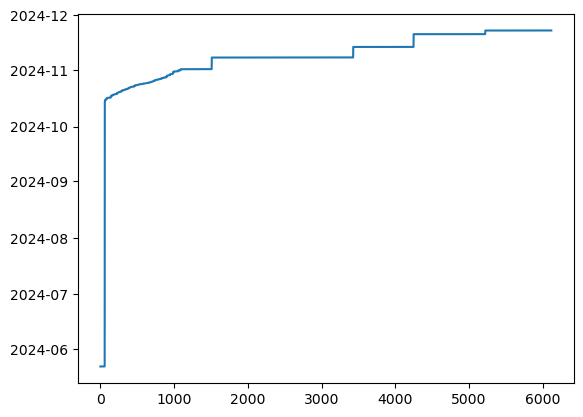

In [10]:
dates = data['dateStored']
plt.plot(range(len(dates)), dates)
plt.savefig(os.path.join(PLOT_FOLDER_PATH, 'vehicle_15_all_trips'))
plt.show()


Plot velocity

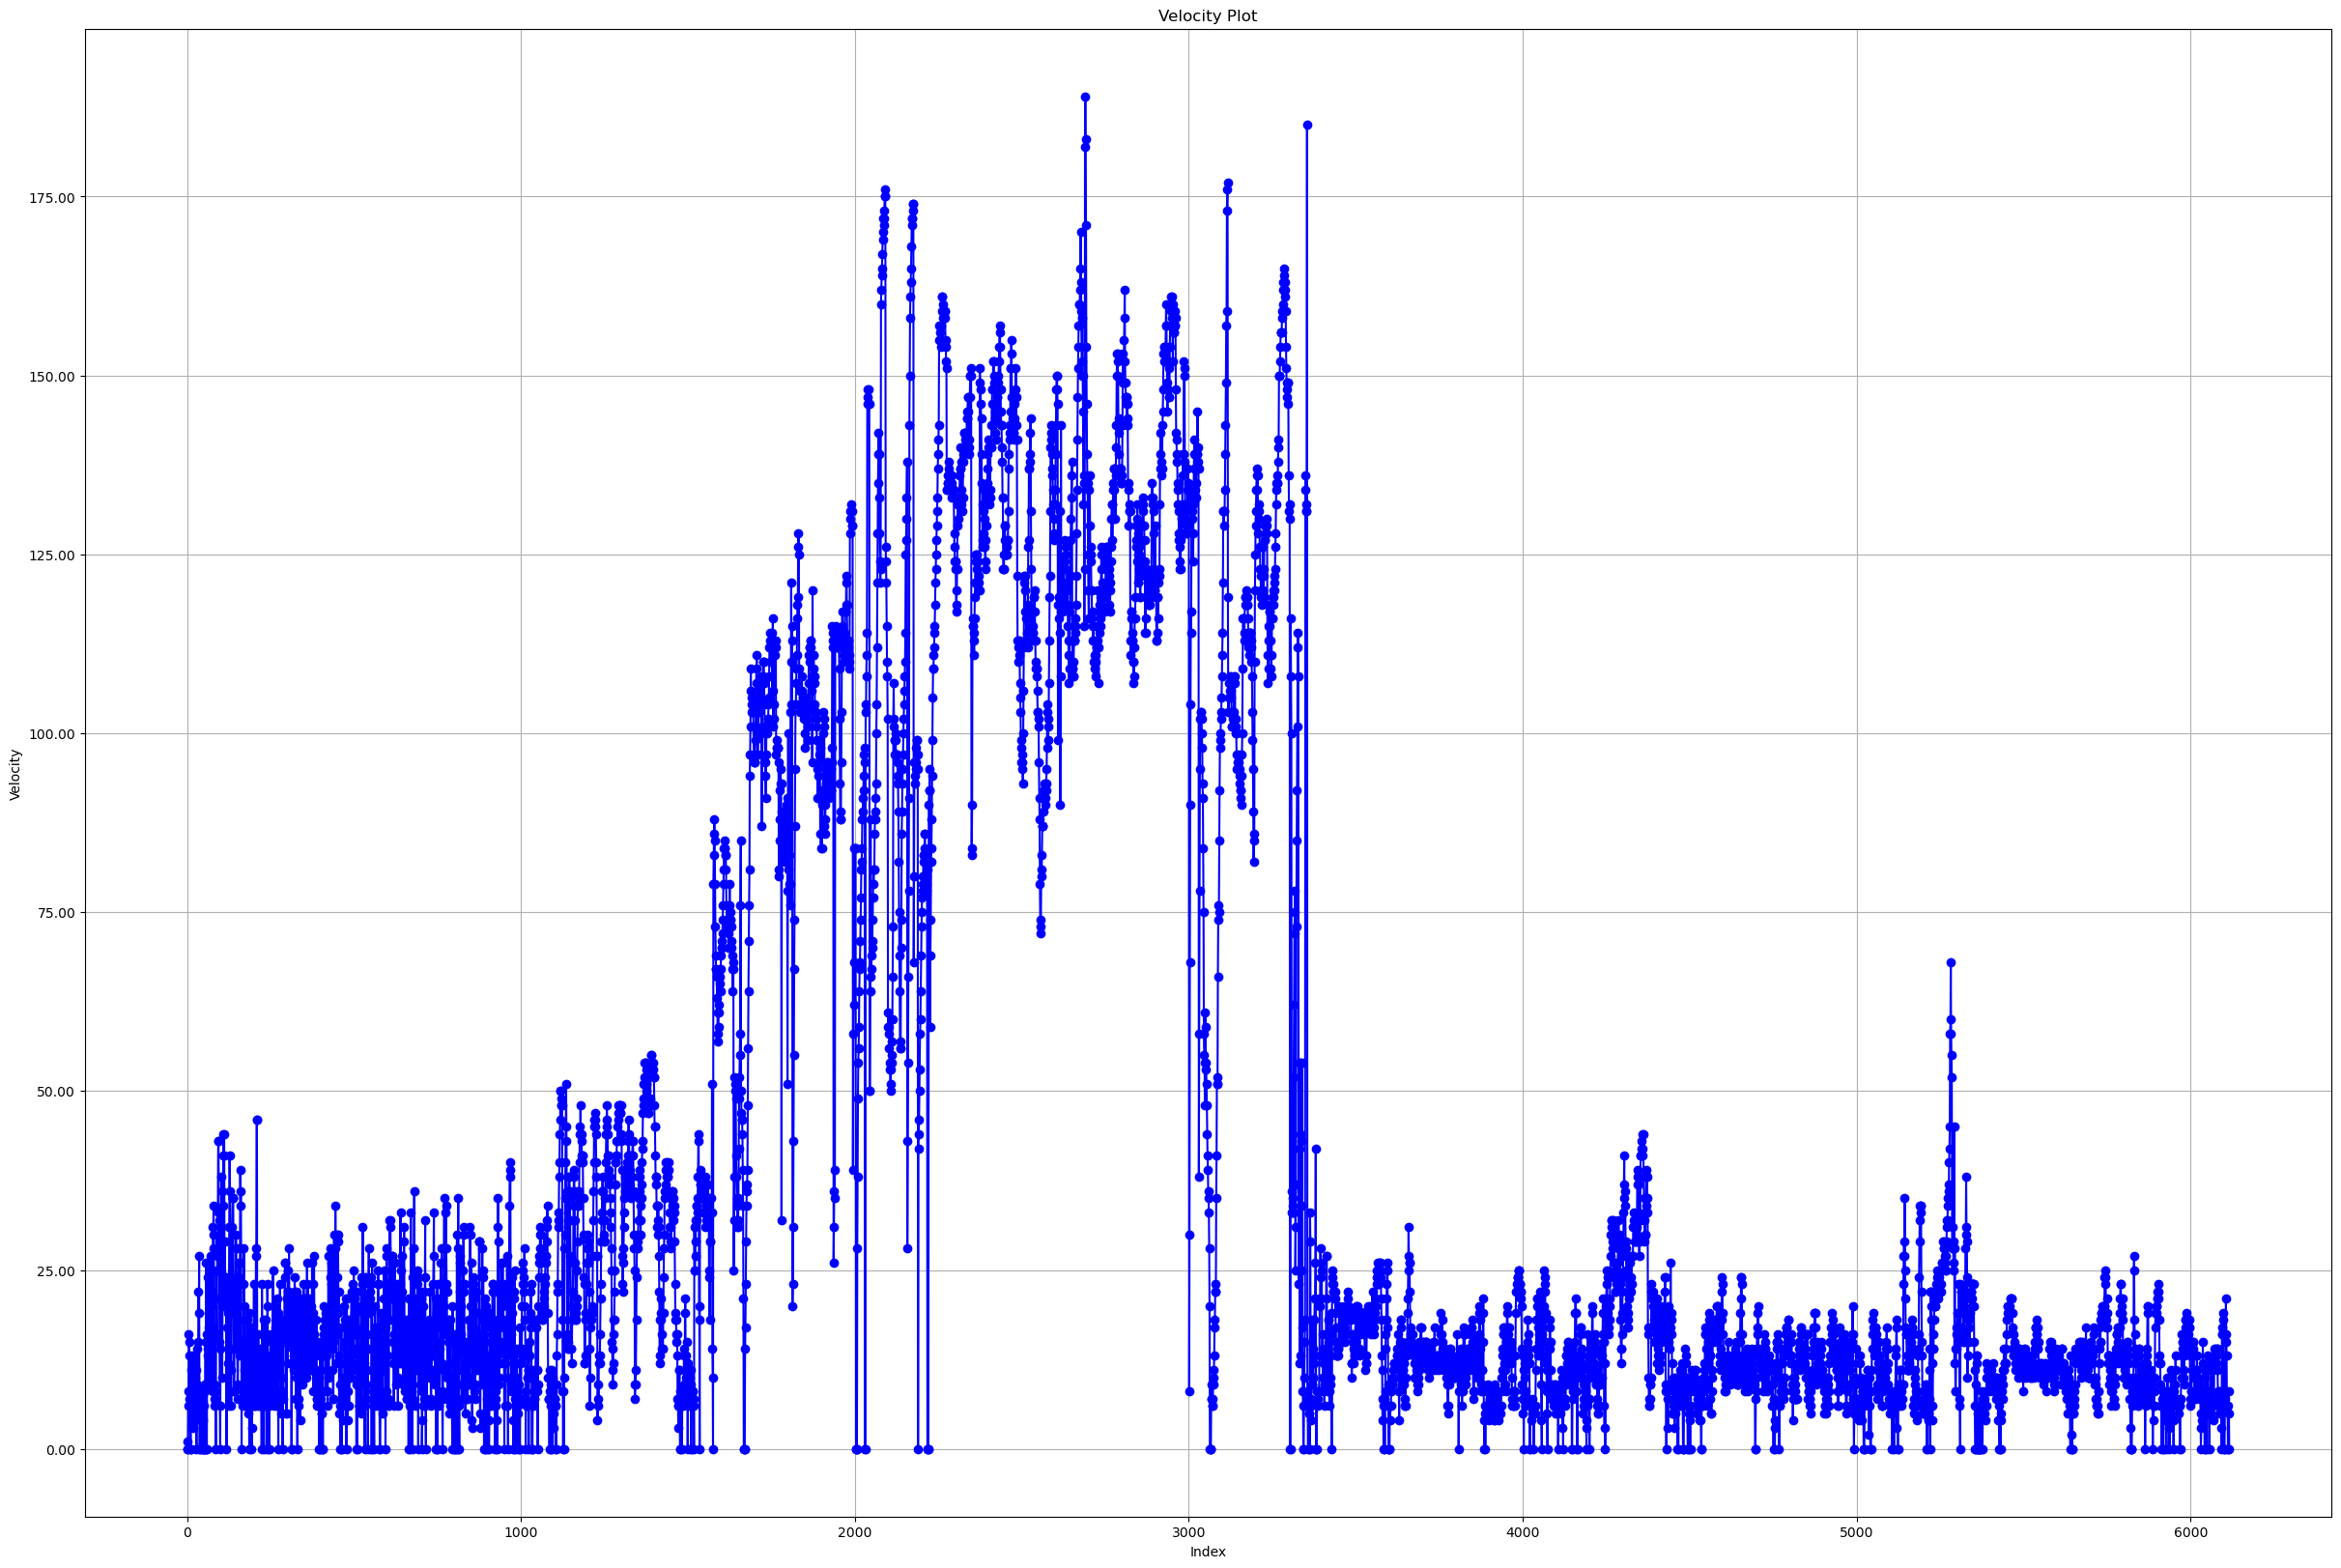

In [11]:
velocities = data_sorted['velocity']

plt.figure(figsize=(30, 20))
plt.plot(velocities, marker='o', linestyle='-', color='b')
plt.title('Velocity Plot')
plt.xlabel('Index')
plt.ylabel('Velocity')


# Ensure y-axis ticks are formatted as floats
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))


plt.grid(True)
plt.show()


- Calculate which the **30 degrees turns** on coordinatess
- Plot the **30 degrees turns** vs velocities **before and after** making the turn

| Decimal Places | Latitude Precision (meters) | Longitude Precision (meters at Equator) |
|----------------|-----------------------------|-----------------------------------------|
| 1              | ~11,132 m                   | ~11,132 m                               |
| 2              | ~1,113 m                    | ~1,113 m                                |
| 3              | ~111.3 m                    | ~111.3 m                                |
| 4              | ~11.13 m                    | ~11.13 m                                |
| 5              | ~1.113 m                    | ~1.113 m                                |
| 6              | ~0.1113 m                   | ~0.1113 m                               |
| 7              | ~0.01113 m                  | ~0.01113 m                              |
| 8              | ~0.001113 m                 | ~0.001113 m                             |

In [ ]:
def process_coordinates(data_sorted):
    # Load the dataset into a GeoDataFrame
    gdf = gpd.GeoDataFrame(data_sorted, geometry=gpd.points_from_xy(data_sorted['lng'], data_sorted['lat']))

    # Function to calculate precision correspondences
    def calculate_precision_distances():
        precision_list = []
        for decimals in range(1, 9):  # For 1 to 8 decimals
            latitude_precision = 111_320 / (10**decimals)  # Latitude: meters
            longitude_precision = latitude_precision  # Assuming equator (lat = 0)
            precision_list.append((decimals, latitude_precision, longitude_precision))
        return precision_list

    # Calculate precision distances
    precisions = calculate_precision_distances()

    # Create a DataFrame for output
    precision_df = pd.DataFrame(precisions, columns=['Decimal Places', 'Latitude Precision (m)', 'Longitude Precision (m)'])
    print(precision_df)

    # Function to get the latest and next coordinate
    def get_latest_and_next_coordinates(gdf):
        latest_coordinate = gdf.iloc[-1]  # The last entry is the latest coordinate
        print("Latest coordinate:", latest_coordinate)

        # Get next coordinates for each row (if any)
        next_coordinates = []
        for idx in range(len(gdf) - 1):
            current_row = gdf.iloc[idx]
            next_row = gdf.iloc[idx + 1]
            next_coordinates.append((current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng']))
        
        return latest_coordinate, next_coordinates

    # Get the latest and next coordinates
    latest_coordinate, next_coordinates = get_latest_and_next_coordinates(gdf)

    # Print the results
    print("\nLatest Coordinate:")
    print(latest_coordinate[['lat', 'lng']])

    print("\nNext Coordinates:")
    for coord in next_coordinates:
        print(f"Current: ({coord[0]}, {coord[1]}) -> Next: ({coord[2]}, {coord[3]})")

    return latest_coordinate, next_coordinates


#* Assuming 'data_sorted' is already defined as a DataFrame with columns 'lat' and 'lng'
latest_coordinate, next_coordinates = process_coordinates(data_sorted)


   Decimal Places  Latitude Precision (m)  Longitude Precision (m)
0               1            11132.000000             11132.000000
1               2             1113.200000              1113.200000
2               3              111.320000               111.320000
3               4               11.132000                11.132000
4               5                1.113200                 1.113200
5               6                0.111320                 0.111320
6               7                0.011132                 0.011132
7               8                0.001113                 0.001113
Latest coordinate: vehicleId                                   15
lat                                  38.050653
lng                                  23.760652
dateStored                 2024-11-22 15:45:03
velocity                                   0.0
odometer                                   0.0
engineVoltage                            4.997
geometry         POINT (23.7606516 38.0506533)
Na